# Analysis for version 0.9.27 on AMD Ryzen 5 3600 6-Core

Copyright 2022 https://www.math-crypto.com -- GNU General Public License

Last edit: 25 Aug 13h CEST

**New**
- The whole analysis can be done with a few simple functions defined in ``mathcrypto.py``.

**How to use?**
- Just define your custom variables below and run all cells!
- Manually inspect the results to see if they make sense.
- Cells that begin with 🤔 can (should) be modified

In [1]:
# standard packages
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib 
import os

# own utils functions
from mathcrypto import * 

# for plotting
matplotlib.rc('xtick', labelsize=12) 
matplotlib.rc('ytick', labelsize=12)
plt.rcParams.update({'font.size': 16})

## 🤔 Define your variables

In [4]:
# Path of feather file containing benchmark scores output. 
# Feather for Extrinsic Timewill be derived from this name.
path = "../processed/todo/0.9.27_Ryzen3600-Aug-23_09h37.feather"
# Name of arch, machine (used for plotting title)
arch = "Ryzen 5 3600"
# Put some info about the benchmark setting
info = "Ubuntu 22.04 server, clean install, rust stable is 1.63"
# What scored and extrinsic to plot
scores = ["BLAKE2-256","SR25519-Verify"]
extrinsics = ["Extr-Remark"]

**From here, you can just run all the code cells below.** (Run -> Run All Cells in Jupyter-labs)

## Read parsed benchmark data. Clean up a bit.

In [5]:
(df, df_ex) = load_both_benchmarks(path)

Max CPU is 1.5%
Max CPU is 1.7%


## Boxplot of all scores

In [11]:
# This assumes the feather is stored as
#   processed/todo/VERSION_HOSTNAME_DATE_TIME.feather
id_string = "v" + (".").join(path.split("/")[-1].split(".")[0:-1])
image_dir = "images/"+id_string
try:
    os.makedirs(image_dir)
except:
    pass

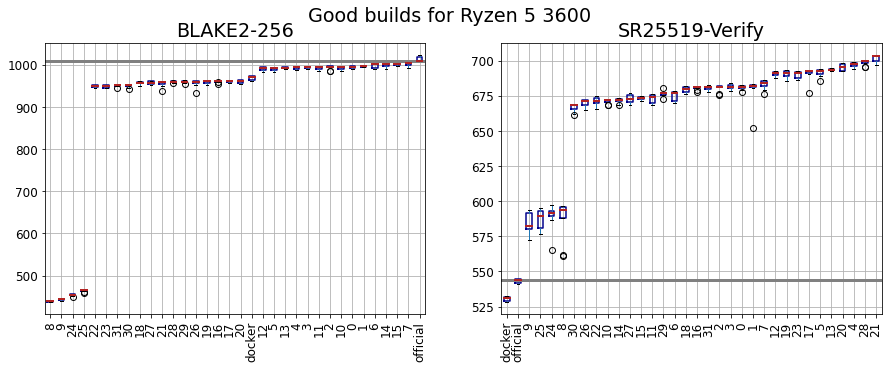

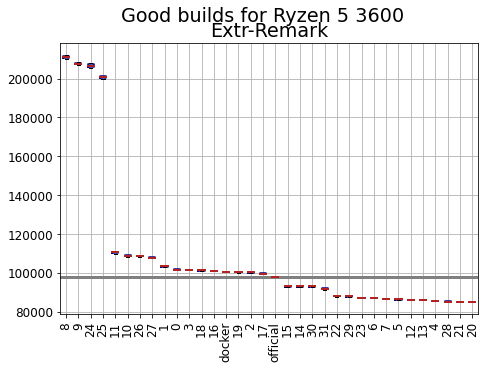

In [12]:
fig = plot_boxplots_df_df_ex(df, scores, df_ex, [])
fig.suptitle("Good builds for " + arch);
fig.savefig(image_dir + "/scores.svg", bbox_inches='tight')
fig = plot_boxplots_df_df_ex(df, [], df_ex, extrinsics)
fig.suptitle("Good builds for " + arch);
fig.savefig(image_dir + "/extrinsics.svg", bbox_inches='tight')

**Remark**: For the timing of the remark extrinsic, smaller values are better!

🤔 We clearly see a few **bad builds**. You could label them here...

In [13]:
# bad_builds = []
bad_builds = ["9", "25", "24", "8"]

## Table of build options

In [14]:
cat_cols = ['nb_build', 'arch', 'toolchain', 'codegen-units', 'lto', 'opt-level']
build_table = df[cat_cols].set_index('nb_build').sort_index().drop_duplicates()
#print( build_table.to_markdown() ) # for website
print("Number of total builds: {}".format(len(build_table)))

Number of total builds: 33


**What are the optimization options of the bad builds?**

In [15]:
bad_table = build_table[build_table.index.isin(bad_builds)]
# print( bad_table.to_markdown() ) # for website
bad_table 

,arch,toolchain,codegen-units,lto,opt-level
nb_build,,,,,
24,native,nightly,16,off,2
25,native,nightly,16,off,3
8,native,stable,16,off,2
9,native,stable,16,off,3


🤔 As usual: It seems that ``codegen-units=16`` and ``lto=off`` is the reason, regardless of ``opt-level``.

## Find winning build options (close to Pareto efficient).

Since it will be useful later, we enrich the values in the scores and extrinsics with a statistical error (in the "Δ-") field).

For simplicity, we assume normality (although not really correct here) sot the errors on the median is 1.25 x error on the mean.

In [16]:
medians = calc_medians_df_df_ex(df, scores, df_ex, extrinsics)
medians = medians.loc[~medians.index.isin(bad_builds)]
medians.round(1).head()

,BLAKE2-256,Δ-BLAKE2-256,SR25519-Verify,Δ-SR25519-Verify,Extr-Remark,Δ-Extr-Remark
nb_build,,,,,,
0,996.0,2.2,681.4,1.2,101240.0,95.6
1,996.4,0.7,681.8,7.4,102878.0,50.5
10,995.7,2.9,671.8,1.2,109179.0,62.7
11,995.5,3.5,673.9,2.4,111114.0,77.2
12,991.7,3.0,691.1,1.3,85977.0,57.8


Since there are *three* objectives now, we do not want to find by hand the Pareto efficient points. Let us therefore **find the (almost) Pareto efficient points in a more automatic way**.

First, we find the **exact Pareto points**.

In [17]:
pareto = find_exact_pareto(medians, scores, extrinsics) 
medians.loc[pareto]

,BLAKE2-256,Δ-BLAKE2-256,SR25519-Verify,Δ-SR25519-Verify,Extr-Remark,Δ-Extr-Remark
nb_build,,,,,,
20,961.640,3.016024,695.850,1.897386,85078.0,26.705
21,959.655,5.732831,703.060,1.963316,85197.0,33.565
28,960.225,1.514335,699.435,1.404520,84936.0,17.885
4,994.205,2.307531,697.395,1.161125,85519.0,20.580
7,1003.545,3.103367,684.050,2.518958,86683.0,45.815
official,1010.000,4.682706,544.080,1.214641,97889.0,21.805


Next, we find all builds that are **close to these Pareto efficient** ones. The width of the boxes is ``2 * delta_scores`` which uses the Δ- values in ``medians``.

In [18]:
delta_scores = ["Δ-" + s for s in scores]
pareto_ext = find_all_points_close(medians, pareto, scores, delta_scores, nudge=1)

print(pareto)        
print(pareto_ext)

['20', '21', '28', '4', '7', 'official']
['17', '20', '21', '28', '4', '7', 'official']


🤔 Choose here if you want to use the extended set, or modify it. You can take ``pareto_sel = pareto_ext`` at first, see what the rest of the analysis brings, and then come back here to modify.

In [19]:
# After inspection, build 17 is a bit weird.
pareto_sel = pareto
df_sel = df[df["nb_build"].isin(pareto_sel)]
df_ex_sel = df_ex[df_ex["nb_build"].isin(pareto_sel)]

Boxplots of the good builds. The horizontal grey line is the median score of the offical polkadot binary.

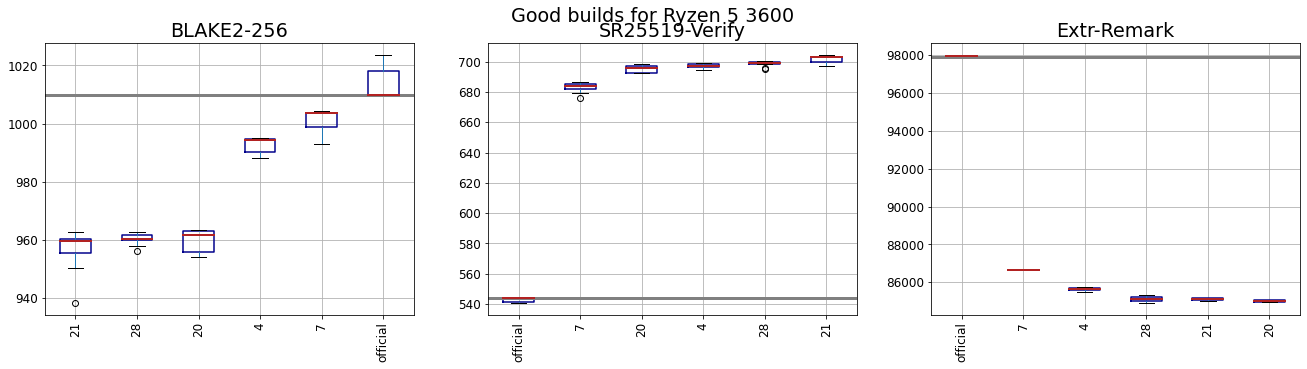

In [20]:
df_sel = df[df["nb_build"].isin(pareto_sel)]
df_ex_sel = df_ex[df_ex["nb_build"].isin(pareto_sel)]
fig = plot_boxplots_df_df_ex(df_sel, scores, df_ex_sel, extrinsics)
fig.suptitle("Good builds for " + arch);
fig.savefig(image_dir + "/pareto.svg", bbox_inches='tight')

## Summary table of winning builds

Table for the overview page of our website.

In [21]:
def statistics_table(medians, scores, extrinsics):
    stats = pd.DataFrame()
    for s in scores:
        median_official = medians[s].loc['official']
        stats[s] = medians[s]
        stats[s + '-improved (%)'] = (stats[s] - median_official)/median_official*100
    for e in extrinsics:
        median_official = medians[e].loc['official']
        stats[e] = medians[e]
        stats[e + '-improved (%)'] = (-1)*(stats[e] - median_official)/median_official*100
    return stats

In [22]:
sum_stats = statistics_table(medians, scores, extrinsics).round(1)
sum_stats_build = pd.concat([sum_stats, build_table[["toolchain", "codegen-units", "lto", "opt-level"]]], axis=1)
sum_sel = sum_stats_build.loc[pareto_sel + ['official', 'docker']]
# print( sum_sel.to_markdown() ) # for website
sum_stats
pareto
sum_sel

,BLAKE2-256,BLAKE2-256-improved (%),SR25519-Verify,SR25519-Verify-improved (%),Extr-Remark,Extr-Remark-improved (%),toolchain,codegen-units,lto,opt-level
nb_build,,,,,,,,,,
20,961.6,-4.8,695.8,27.9,85078.0,13.1,nightly,1.0,fat,2.0
21,959.7,-5.0,703.1,29.2,85197.0,13.0,nightly,1.0,fat,3.0
28,960.2,-4.9,699.4,28.6,84936.0,13.2,nightly,16.0,fat,2.0
4,994.2,-1.6,697.4,28.2,85519.0,12.6,stable,1.0,fat,2.0
7,1003.5,-0.6,684.0,25.7,86683.0,11.4,stable,1.0,thin,3.0
official,1010.0,0.0,544.1,0.0,97889.0,-0.0,NaN,NaN,NaN,NaN
official,1010.0,0.0,544.1,0.0,97889.0,-0.0,NaN,NaN,NaN,NaN
docker,972.1,-3.7,531.0,-2.4,100515.0,-2.7,nightly,16.0,thin local,3.0


🤔 Choose some builds manually here and write some conclusions / observations.

In [23]:
best_builds = ['7', '4']

**Interesting observations**: 
- All builds do worse than the official build for BLAKE2.
- The improvement for SR25519 is very large. For the Extrinsic, there is also a large improvement.

**What are the winning builds?** 
- Surprisingly, ``opt-level=3`` is not always needed. However, some ``lto`` is required. One of the best builds, 7, uses only ``lto=thin``.
- More builds have ``opt-level=2`` than ``opt-level=3``
- It is surprising that build 28 with ``codegen-units=16`` is better than build 20 with ``codegen-units=1``. Both have same options for ``lto=fat`` and ``opt-level=2``.

Not knowing how to distinguinsh here, we keep all **builds (4, 7, 20, 21, 28) as good**. 

It will be interesting to see how these builds compare on different archs (and in future polkadot versions).